In [160]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
#数据准备
Data=namedtuple('Data',['x','y','adjacency','train_mask','val_mask','test_mask'])
def tensor_from_numpy(x,device):
    return torch.from_numpy(x).to(device)
class CoraData(object):
    filenames=['ind.cora.{}'.format(name) for name in ['x','tx','allx','y','ty','ally','graph','test.index']]
    def __init__(self,data_root='data',rebuild=False):
        self.data_root=data_root
        save_file=osp.join(self.data_root,'ch5_cached.pkl')
        if osp.exists(save_file) and not rebuild:
            self._data=pickle.load(open(save_file,'rb'))
        else:
            self._data=self.process_data()
            with open(save_file,'wb') as f:
                pickle.dump(self.data,f)
    @property
    def data(self):
        return self._data
        
    def process_data(self):
        _,tx,allx,y,ty,ally,graph,test_index=[self.read_data(osp.join(self.data_root,name)) for name in self.filenames]
        train_index=np.arange(y.shape[0])
        val_index=np.arange(y.shape[0],y.shape[0]+500)
        sorted_test_index=sorted(test_index)
        x=np.concatenate((allx,tx),axis=0)
        y=np.concatenate((ally,ty),axis=0).argmax(axis=1)
        x[test_index]=x[sorted_test_index]
        y[test_index]=y[sorted_test_index]
        num_nodes=x.shape[0]
        train_mask=np.zeros(num_nodes,dtype=np.bool_)
        val_mask=np.zeros(num_nodes,dtype=np.bool_)
        test_mask=np.zeros(num_nodes,dtype=np.bool_)
        train_mask[train_index]=True
        val_mask[val_index]=True
        test_mask[test_index]=True
        adjacency=self.build_adjacency(graph)
        return Data(x=x,y=y,adjacency=adjacency,train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)
    @staticmethod#类里面写一个函数
    def build_adjacency(adj_dict):
        edge_index=[]
        num_nodes=len(adj_dict)
        for src,dst in adj_dict.items():
            edge_index.extend([src,v] for v in dst)
            edge_index.extend([v,src] for v in dst)
        edge_index=list(k for k,_ in itertools.groupby(sorted(edge_index)))
        edge_index=np.asarray(edge_index)
        adjacency=sp.coo_matrix((np.ones(len(edge_index)),(edge_index[:,0],edge_index[:,1])),shape=(num_nodes,num_nodes),dtype='float32')
        return adjacency
    @staticmethod
    def read_data(path):
        name=osp.basename(path)
        if name=='ind.cora.test.index':
            out=np.genfromtxt(path,dtype='int64')
            return out
        else:
            out=pickle.load(open(path,'rb'),encoding='latin1')
            out=out.toarray() if hasattr(out,'toarray') else out
            return out
    @staticmethod 
    def normalization(adjacency):
        adjacency+=sp.eye(adjacency.shape[0])
        degree=np.array(adjacency.sum(1))
        d_hat=sp.diags(np.power(degree,-0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocoo()

In [162]:
#图卷积层定义
class GraphConvolution(nn.Module):
    def __init__(self,input_dim,output_dim,use_bias=True):
        super(GraphConvolution,self).__init__()
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.use_bias=use_bias
        self.weight=nn.Parameter(torch.Tensor(input_dim,output_dim))
        if self.use_bias:
            self.bias=nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias',None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)
    def forward(self,adjacency,input_feature):
        support=torch.mm(input_feature,self.weight)
        output=torch.sparse.mm(adjacency,support)
        if self.use_bias:
            output+=self.bias
        return output
    def __repr__(self):
        return self.__class__.__name__+'('+str(self.input_dim)+'->'+str(self.output_dim)+')'

In [163]:
#模型定义
class GcnNet(nn.Module):
    def __init__(self,input_dim=1433):
        super(GcnNet,self).__init__()
        self.gcn1=GraphConvolution(input_dim,16)
        self.gcn2=GraphConvolution(16,7)
    def forward(self,adjacency,feature):
        h=F.relu(self.gcn1(adjacency,feature))
        logits=self.gcn2(adjacency,h)
        return logits

In [164]:
#模型训练
LEARNING_RATE=0.1
WEIGHT_DECAY=5e-4
EPOCHS=200
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

In [165]:
#加载数据，转换为torch.Tensor
dataset=CoraData().data
node_feature=dataset.x/dataset.x.sum(1,keepdims=True)
tensor_x=tensor_from_numpy(node_feature,DEVICE)
tensor_y=tensor_from_numpy(dataset.y,DEVICE)
tensor_train_mask=tensor_from_numpy(dataset.train_mask,DEVICE)
tensor_val_mask=tensor_from_numpy(dataset.val_mask,DEVICE)
tensor_test_mask=tensor_from_numpy(dataset.test_mask,DEVICE)
normalize_adjacency=CoraData.normalization(dataset.adjacency)
num_nodes,input_dim=node_feature.shape
indices=torch.from_numpy(np.asarray([normalize_adjacency.row,normalize_adjacency.col]).astype('int64')).long()
values=torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency=torch.sparse.FloatTensor(indices,values,(num_nodes,num_nodes)).to(DEVICE)

In [166]:
#模型定义
model=GcnNet(input_dim).to(DEVICE)
criterion=nn.CrossEntropyLoss().to(DEVICE)
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

In [167]:
#训练函数
def train():
    loss_history=[]
    val_acc_history=[]
    model.train()
    train_y=tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits=model(tensor_adjacency,tensor_x)#前向传播
        train_mask_logits=logits[tensor_train_mask]
        loss=criterion(train_mask_logits,train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc,_,_=test(tensor_train_mask)
        val_acc,_,_=test(tensor_val_mask)
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print('epoch{:03d}:loss{:.4f},trainAcc{:.4f},ValAcc:{:.4f}'.format(epoch,loss.item(),train_acc.item(),val_acc.item()))
    return loss_history,val_acc_history

In [168]:
def test(mask):
    model.eval()
    with torch.no_grad():
        logits=model(tensor_adjacency,tensor_x)
        test_mask_logits=logits[mask]
        predict_y=test_mask_logits.max(1)[1]
        accuarcy=torch.eq(predict_y,tensor_y[mask]).float().mean()
    return accuarcy,test_mask_logits.cpu().numpy(),tensor_y[mask].cpu().numpy()

In [169]:
def plot_loss_with_acc(loss_history,val_acc_history):
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    ax1.plot(range(len(loss_history)),loss_history,c=np.array([255,71,90])/255.)
    plt.ylabel('loss')

    ax2=fig.add_subplot(111,sharex=ax1,frameon=False)
    ax2.plot(range(len(val_acc_history)),val_acc_history,c=np.array([79,179,255])/255.)
    ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
    ax2.yaxis.set_label_position('right')
    plt.ylabel('ValAcc')
    plt.xlabel('epoch')
    plt.title('training loss & validation accuracy')
    plt.show()

In [170]:
loss,val_acc=train()
test_acc,test_logits,test_label=test(tensor_test_mask)
print('test accuarcy',test_acc.item())

epoch000:loss1.9493,trainAcc0.1571,ValAcc:0.0660
epoch001:loss1.8954,trainAcc0.5357,ValAcc:0.3840
epoch002:loss1.8309,trainAcc0.7286,ValAcc:0.6780
epoch003:loss1.7352,trainAcc0.8714,ValAcc:0.6700
epoch004:loss1.6163,trainAcc0.8571,ValAcc:0.5900
epoch005:loss1.4885,trainAcc0.9143,ValAcc:0.6920
epoch006:loss1.3404,trainAcc0.9357,ValAcc:0.7360
epoch007:loss1.1803,trainAcc0.9429,ValAcc:0.7500
epoch008:loss1.0168,trainAcc0.9500,ValAcc:0.7480
epoch009:loss0.8666,trainAcc0.9500,ValAcc:0.7660
epoch010:loss0.7286,trainAcc0.9571,ValAcc:0.7760
epoch011:loss0.6082,trainAcc0.9786,ValAcc:0.7640
epoch012:loss0.5058,trainAcc0.9857,ValAcc:0.7840
epoch013:loss0.4225,trainAcc0.9857,ValAcc:0.7980
epoch014:loss0.3584,trainAcc0.9857,ValAcc:0.7940
epoch015:loss0.3082,trainAcc0.9857,ValAcc:0.7940
epoch016:loss0.2705,trainAcc0.9857,ValAcc:0.7880
epoch017:loss0.2440,trainAcc0.9857,ValAcc:0.7840
epoch018:loss0.2244,trainAcc0.9929,ValAcc:0.7840
epoch019:loss0.2108,trainAcc1.0000,ValAcc:0.7860
epoch020:loss0.2029,

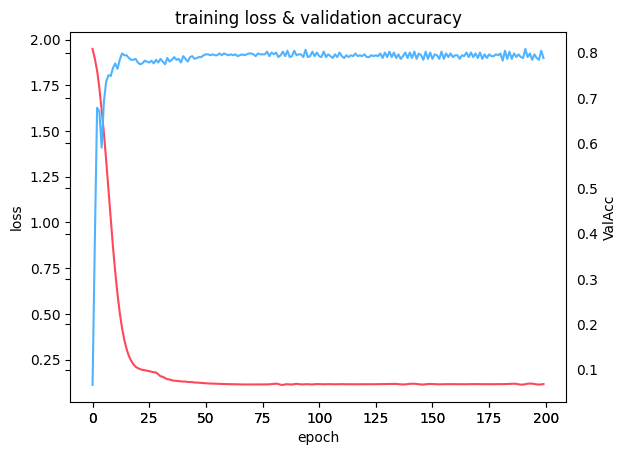

In [171]:
plot_loss_with_acc(loss,val_acc)

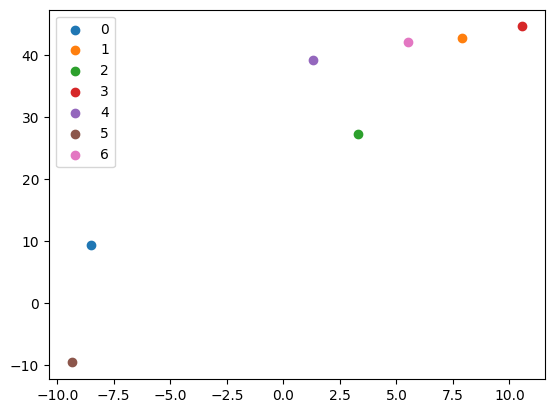

In [172]:
#绘制TSNE降维图
from sklearn.manifold import TSNE
tsne=TSNE()
out=tsne.fit_transform(test_logits)
fig=plt.figure()
for i in range(7):
    indices=test_label=i
    x,y=out[indices].T
    plt.scatter(x,y,label=str(i))
plt.legend()  # 显示图例
plt.show()  # 显示图形